# ISLR-Python: Ch7- Applied 2

In [44]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from collections import defaultdict
from functools import partial
from patsy import bs, dmatrix

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

np.set_printoptions(precision=4)

## Import Data

In [28]:
Wages = pd.read_csv('../../../data/Wage.csv')
Wages=Wages.set_index(keys=['Unnamed: 0'], drop=True)
del Wages.index.name
Wages.head(3)

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


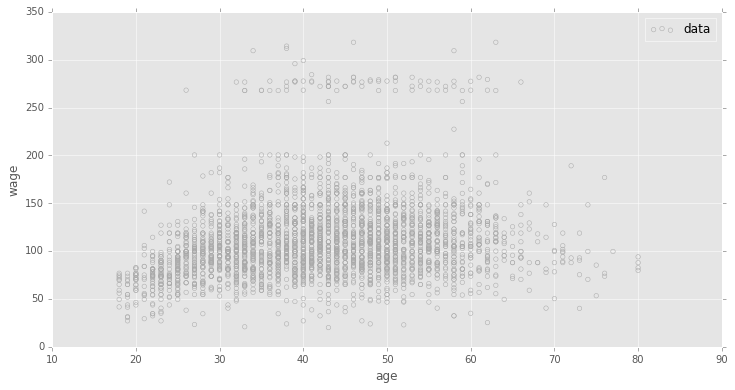

In [29]:
# Plot the age and wage again
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.scatter(Wages.age, Wages.wage, facecolors='none', edgecolors='darkgray', label='data')
ax.set_xlabel('age');
ax.set_ylabel('wage');
ax.legend(loc='best');

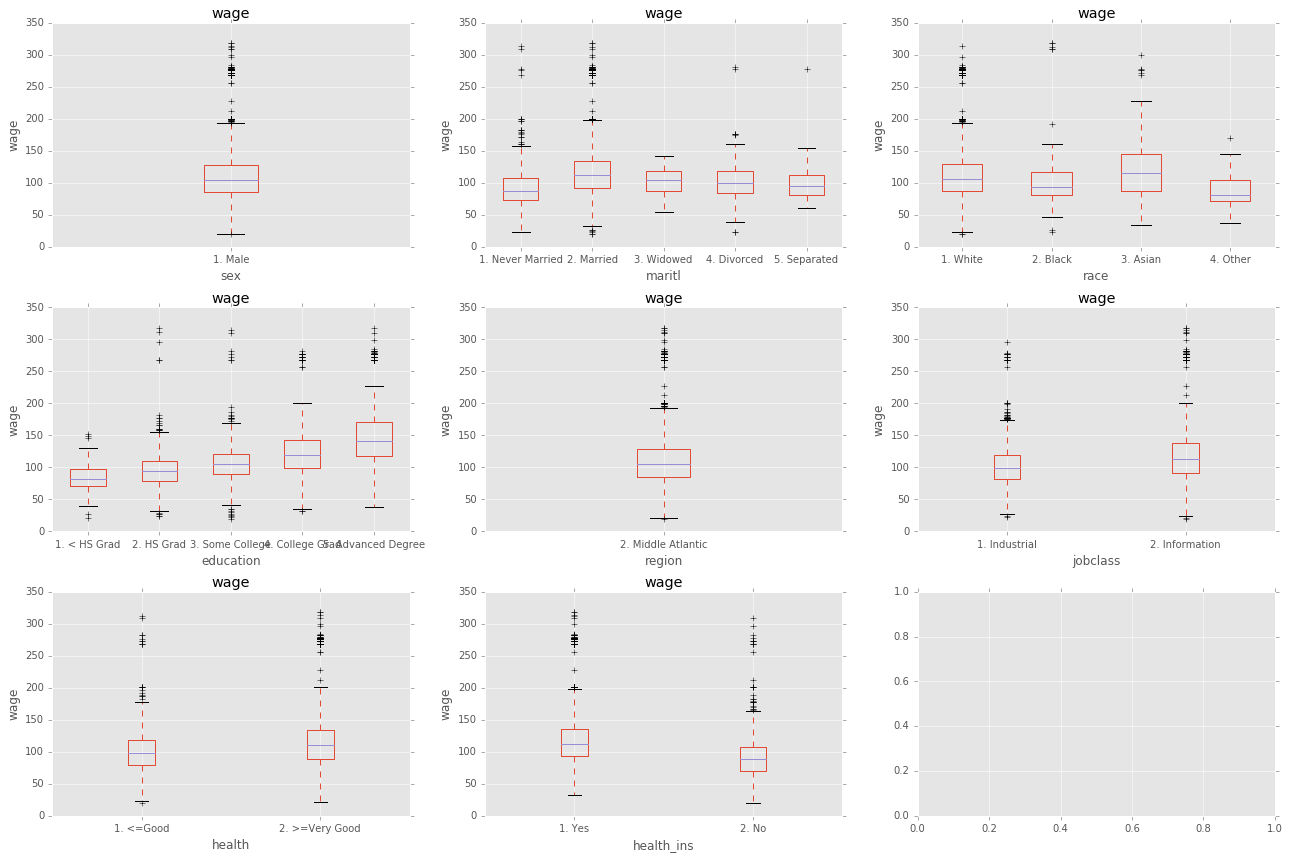

In [30]:
# Boxplots of the categoricals
fig, axarr = plt.subplots(3,3,figsize = (18,12))
# lets look at all the remaining categoricals we did not explore in the lab
categoricals = ['sex', 'maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins']
for el, categorical in enumerate(categoricals):
    index = np.unravel_index(el,(3,3))
    Wages.boxplot(column='wage', by=categorical,ax=axarr[index[0], index[1]]);
    axarr[index[0], index[1]].set_xlabel(categorical);
    axarr[index[0], index[1]].set_ylabel('wage');
    plt.tight_layout()
plt.suptitle('');

## Genearlize Additive model

Lets make a generalized additive model using the year, age, education and health_ins. Since we already know that year is somewhat linear and age is non-linear (by our plot above). Then we will fit a linear yr term and a natural spline age term plus the categorical.

In [141]:
# Build a design matix using Patsy #
####################################
# remember a GAM is just one large linear regression onto basis functions in the case that the smoothing 
# functions are natural splines
design = dmatrix("year + cr(age, df=5, constraints='center') + education + health_ins",
                 data={"year":Wages.year, "age":Wages.age, "education":Wages.education,
                       "health_ins": Wages.health_ins}, return_type="dataframe")
# Fit Statsmodels OLS #
########################
# Again a GAM is just one large linear regression onto splines basis funcs so just construct an OLS model.
gam = sm.OLS(endog=Wages.wage, exog=design).fit()
print(gam.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     130.7
Date:                Fri, 02 Dec 2016   Prob (F-statistic):          3.72e-245
Time:                        13:32:41   Log-Likelihood:                -14861.
No. Observations:                3000   AIC:                         2.975e+04
Df Residuals:                    2988   BIC:                         2.982e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------

Now in the lab we made plots of each of the smoothing functions by computing the dot product of the gam's coeffecients with the columns of the design matrix that correspond to each basis function. Here we are going to roll that process into a function since its seems like we will use it over and over again.

In [142]:
design.columns.values

array(['Intercept', 'education[T.2. HS Grad]',
       'education[T.3. Some College]', 'education[T.4. College Grad]',
       'education[T.5. Advanced Degree]', 'health_ins[T.2. No]', 'year',
       "cr(age, df=5, constraints='center')[0]",
       "cr(age, df=5, constraints='center')[1]",
       "cr(age, df=5, constraints='center')[2]",
       "cr(age, df=5, constraints='center')[3]",
       "cr(age, df=5, constraints='center')[4]"], dtype=object)

In [143]:
gam.params

Intercept                                -2400.437904
education[T.2. HS Grad]                      8.284311
education[T.3. Some College]                19.327580
education[T.4. College Grad]                33.316446
education[T.5. Advanced Degree]             57.075372
health_ins[T.2. No]                        -16.991120
year                                         1.243776
cr(age, df=5, constraints='center')[0]       5.429938
cr(age, df=5, constraints='center')[1]      26.050683
cr(age, df=5, constraints='center')[2]      16.677089
cr(age, df=5, constraints='center')[3]       4.903268
cr(age, df=5, constraints='center')[4]     -26.108184
dtype: float64

## GAM Plotting Function

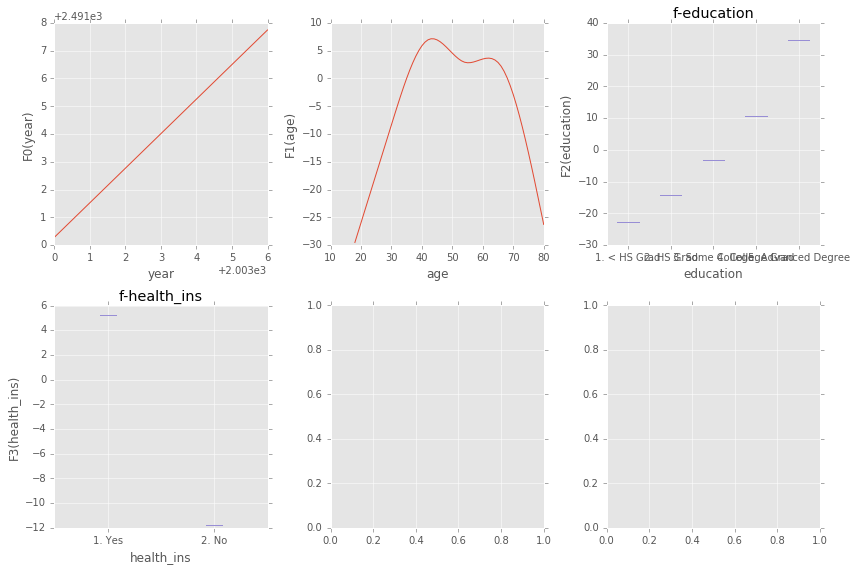

In [193]:
def gam_plot(data, design, gam_model, predictors):
    """
    A method to plot fitted basis functions similar to R's gam library and associated plot method.
    
    Parameters:
        data:       Original DataFrame containing all features.
        design:     An n_samples by n_features design dataframe with basis functions created using Patsy.
        gam_model:  A statsmodel fitted OLS object. 
        predictors: A list of string names for each of the predictors used to construct the gam.
        
        TO DO: Add SE bars
    """
    basis_funcs = defaultdict(np.array,[])
    extremums = defaultdict(list)
    
    # Compute the product of the design df with the coeffecients
    results = design * gam.params
    # find the columns that have the predictor in the col name and get the results from these columns
    for predictor in predictors:
        column_names = [col for col in design.columns if predictor in col]
        basis_funcs[predictor] = results[column_names]
        
        
    # Plotting
    num_rows = len(predictors)//3 + 1 if len(predictors)%3!=0 else len(predictors)//3
    fig, axarr = plt.subplots(num_rows, 3, figsize=(12,8))
    
    for el, predictor in enumerate(predictors):
        # get the tuple index to plot to
        plt_index = np.unravel_index(el,(num_rows, 3))
        
        # numeric predictors
        if data[predictor].values.dtype.type is np.int64:
            # get the order of the predictor and make a grid
            order = np.argsort(data[predictor])
            predictor_grid = data[predictor].values[order]
            # sum the basis functions and order the same as the predictor
            basis_vals = np.sum(basis_funcs[predictor].values, axis=1)[order]
            axarr[plt_index[0], plt_index[1]].plot(predictor_grid, basis_vals)
            
        else:
            # categorical predictors
            # make a temporary data frame
            s = pd.DataFrame(data[predictor])
            # add the sum of the basis functions for this categorical predictor
            s['f-'+predictor] = np.sum(basis_funcs[predictor].values, axis=1)
            # zero-mean
            s['f-'+predictor] = s['f-'+predictor] - s['f-'+predictor].mean()
            # call boxplot grouping by predictor col
            s.boxplot(column=['f-'+predictor], by=predictor, ax = axarr[plt_index[0], plt_index[1]]);
            axarr[plt_index[0], plt_index[1]].set_ylabel('F%d(%s)' %(el,predictor));
            plt.suptitle('')
            
        # Add Labels
        axarr[plt_index[0], plt_index[1]].set_xlabel(predictor);
        axarr[plt_index[0], plt_index[1]].set_ylabel('F%d(%s)' % (el,predictor));
        plt.tight_layout() 
                
    return basis_funcs
    
bfs = gam_plot(data = Wages, design=design, gam_model=gam, predictors=['year', 'age', 'education', 'health_ins'])

From this it appears health Insurance is also an important feature to consider when predicting wage. Lets do an ANOVA Test to confirm this.

In [195]:
# Model W/o health_ins #
########################
design0 = dmatrix("year + cr(age, df=5, constraints='center') + education",
                 data={"year":Wages.year, "age":Wages.age, "education":Wages.education}, return_type="dataframe")
gam0 = sm.OLS(endog=Wages.wage, exog=design0).fit()

# Model With health_ins #
#########################
design1 = dmatrix("year + cr(age, df=5, constraints='center') + education + health_ins",
                 data={"year":Wages.year, "age":Wages.age, "education":Wages.education,
                       "health_ins": Wages.health_ins}, return_type="dataframe")
gam1 = sm.OLS(endog=Wages.wage, exog=design1).fit()

# ANOVA #
#########
# ANOVA TEST
anova = sm.stats.anova_lm(gam0, gam1)
print(anova)

   df_resid           ssr  df_diff       ss_diff           F        Pr(>F)
0    2989.0  3.695015e+06      0.0           NaN         NaN           NaN
1    2988.0  3.526083e+06      1.0  168931.81163  143.152679  2.935280e-32


So the p-value for the no insurance is very low indicating that there is strong evidence that health_insurance status should be included in the model. Of course now that we have a handy function for plotting the GAM results, we could look at all the other categorical features as well.